# Modélisation

## Importation des modules

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

#Preprocess
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error 
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MultiLabelBinarizer, FunctionTransformer

#Modèles
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from xgboost import XGBRegressor

In [13]:
# Fonction pour calculer la racine carrée de l'erreur quadratique moyenne
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [14]:
def plot_compare_scores(score_df, column1_name, column2_name):
    data = {
    'Model': score_df.index.tolist(),
    column1_name: score_df[column1_name].tolist(),
    column2_name: score_df[column2_name].tolist()
    }

    df = pd.DataFrame(data)

    # Création du graphique
    plt.figure(figsize=(12, 6))

    # Position des barres
    x = np.arange(len(df['Model']))
    width = 0.35

    # Création des barres
    plt.bar(x - width/2, df[column1_name], width, label=column1_name, color='lightcoral')
    plt.bar(x + width/2, df[column2_name], width, label=column2_name, color='skyblue')

    # Personnalisation du graphique
    plt.xlabel('Modèles')
    plt.ylabel('Score R2')
    plt.title(f'Comparaison des scores {column2_name} et {column1_name}  par modèle', pad=20)
    plt.xticks(x, df['Model'], rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Ajout d'une ligne horizontale à y=0
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # Ajustement automatique des marges
    plt.tight_layout()

    # Affichage du graphique
    plt.show()

    # Calcul et affichage de la différence entre les 2 scores
    df['Difference'] = abs(df[column2_name] - df[column1_name])
    df = df.sort_values('Difference', ascending=False)
    print(f"\nDifférence entre R2 {column2_name} et {column1_name} (triée par ordre décroissant):")
    print(df[['Model', column2_name, column1_name, 'Difference']])

## Importation des données

In [15]:
building_consumption = pd.read_csv("data/2016_Building_Energy_Benchmarking.csv")
building_consumption.shape

(3376, 46)

In [16]:
building_consumption["BuildingType"].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [17]:
building_consumption = building_consumption.loc[building_consumption["BuildingType"].isin(["NonResidential", 
                                                                                         "Nonresidential COS", 
                                                                                         "SPS-District K-12",
                                                                                         "Campus",
                                                                                         "Nonresidential WA"])]

In [18]:
building_consumption.shape

(1668, 46)

In [19]:
# Suppression des colonnes qu'on n'a pas besoin ou de string de cardinalité trop élevé
building_consumption.drop(columns=["OSEBuildingID",
                                   "City",
                                   "State",
                                   "Address",
                                   "Comments", 
                                   "PropertyName",
                                   'Longitude',
                                   'Latitude',
                                   "YearsENERGYSTARCertified",
                                   "DefaultData",
                                   "TaxParcelIdentificationNumber",
                                   "SecondLargestPropertyUseTypeGFA", 
                                   #"ListOfAllPropertyUseTypes",
                                   "ThirdLargestPropertyUseTypeGFA"], inplace=True)
building_consumption.shape

(1668, 33)

In [20]:
# Suppression des colonnes qui sont basées sur la colonne de target pour éviter le data leakage
building_consumption.drop(columns=["SiteEnergyUseWN(kBtu)", 
                       'SiteEUI(kBtu/sf)', 
                       'SourceEUI(kBtu/sf)',
                       'SourceEUIWN(kBtu/sf)',
                       'SiteEUIWN(kBtu/sf)',
                       'Electricity(kBtu)', 
                       'Electricity(kWh)', 
                       'NaturalGas(kBtu)',
                       'NaturalGas(therms)',
                       'SteamUse(kBtu)',
                       'SiteEnergyUseWN(kBtu)',
                       'GHGEmissionsIntensity',
                       'ENERGYSTARScore'], inplace=True)
building_consumption.shape

(1668, 21)

In [21]:
# Calcul de la matrice de corrélation
corr_matrix = building_consumption.corr().abs()

# Création d'une matrice triangulaire supérieure
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identification des colonnes à supprimer
to_drop = ['PropertyGFABuilding(s)', 
           'LargestPropertyUseTypeGFA']

# Supprimer des colonnes trop corrélés
building_consumption.drop(columns=to_drop, inplace=True)

building_consumption.shape

/var/folders/b8/_p_1v95j6ql648xwdw382p9h0000gn/T/ipykernel_66982/950933719.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = building_consumption.corr().abs()


(1668, 19)

In [22]:
building_consumption.columns.values

array(['DataYear', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'SiteEnergyUse(kBtu)',
       'ComplianceStatus', 'Outlier', 'TotalGHGEmissions'], dtype=object)

#### Détection des lignes qu'on n'a pas besoin

In [11]:
# Calculer la moyenne de NumberofBuildings par PrimaryPropertyType
# mean_buildings = building_consumption.groupby('PrimaryPropertyType')['NumberofBuildings'].transform('mean')

# Remplir les valeurs manquantes avec la moyenne correspondante
# building_consumption['NumberofBuildings'] = building_consumption['NumberofBuildings'].fillna(mean_buildings)

# Calculer la moyenne de NumberofFloors par PrimaryPropertyType
# mean_floors = building_consumption.groupby('PrimaryPropertyType')['NumberofFloors'].transform('mean')

# Remplir les valeurs manquantes avec la moyenne correspondante
# building_consumption['NumberofFloors'] = building_consumption['NumberofFloors'].fillna(mean_floors)

In [23]:
# Supprimer les lignes dont les codes postales sont vide et dont les lignes sont des outliers
building_consumption = building_consumption.loc[~building_consumption["ZipCode"].isnull(), :]

# Supprimer les lignes des années de contructions qui sont vides
building_consumption =  building_consumption.loc[~building_consumption["YearBuilt"].isnull()]

building_consumption.shape

(1652, 19)

In [24]:
# Suppression des outliers
building_consumption = building_consumption.loc[(building_consumption["PropertyGFATotal"] < 3000000) &
                                          (building_consumption["NumberofBuildings"] < 23) &
                                          (building_consumption["Outlier"].isnull()) &
                                          (building_consumption["ComplianceStatus"] == "Compliant") &
                                          (building_consumption["NumberofFloors"] > 0) &
                                          (building_consumption["NumberofBuildings"] > 0) &
                                          (building_consumption["TotalGHGEmissions"] > 0)]

building_consumption.drop(columns=["Outlier","ComplianceStatus"], axis=1, inplace=True)
building_consumption.shape

(1464, 17)

In [25]:
target_df = building_consumption[["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]]
building_consumption = building_consumption.drop(columns=["TotalGHGEmissions", "SiteEnergyUse(kBtu)"])

##  Feature engineering

In [46]:
target_df

,TotalGHGEmissions,SiteEnergyUse(kBtu)
0,249.98,7226362.50
1,295.86,8387933.00
2,2089.28,72587024.00
3,286.43,6794584.00
4,505.01,14172606.00
...,...,...
3339,134.80,4420650.50
3340,67.65,2925780.00
3347,9.24,1325972.75
3356,1000.06,39364116.00


In [26]:
building_consumption.shape

(1464, 15)

### Création de pipeline avec les étapes de traîtement en haut

In [27]:
class UsageCountTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['CountUsage'] = X_copy.apply(
            lambda row: sum(1 for col in ['PrimaryPropertyType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
                          if row[col]), axis=1
        )
        return X_copy.drop(columns=['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'])

class DistrictDensityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.district_density = None
    
    def fit(self, X, y=None):
        self.district_density = X.groupby('CouncilDistrictCode')['PropertyGFATotal'].mean()
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['DistrictDensity'] = X_copy['CouncilDistrictCode'].map(self.district_density)
        return X_copy
    

class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["BuildingAge"] = X_copy["DataYear"] - X_copy["YearBuilt"]
        X_copy["GFAPerFloor"] = (X_copy["PropertyGFATotal"] / X_copy["NumberofFloors"]).round(2)
        X_copy["GFAPerBuilding"] = (X_copy["PropertyGFATotal"] / X_copy["NumberofBuildings"]).round(2)
        X_copy["ParkingGFARate"] = (X_copy["PropertyGFAParking"] / X_copy["PropertyGFATotal"]).round(2)
        return X_copy

class TypeConversionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["ZipCode"] = X_copy["ZipCode"].astype(int).astype(str)
        X_copy["CouncilDistrictCode"] = X_copy["CouncilDistrictCode"].astype(str)
        X_copy["YearBuilt"] = X_copy["YearBuilt"].astype(str)
        return X_copy.drop(columns=["DataYear"])

class PropertyTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()
        
    def fit(self, X, y=None):
        property_types = X["ListOfAllPropertyUseTypes"].str.split(',').apply(lambda x: [tag.strip() for tag in x])
        self.mlb.fit(property_types)
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        property_types = X_copy["ListOfAllPropertyUseTypes"].str.split(',').apply(lambda x: [tag.strip() for tag in x])
        tags_encoded = pd.DataFrame(
            self.mlb.transform(property_types),
            columns=self.mlb.classes_,
            index=X_copy.index
        )
        X_copy["TotalUseType"] = len(property_types)
        X_copy = X_copy.drop(["ListOfAllPropertyUseTypes"], axis=1)
        return pd.concat([X_copy, tags_encoded], axis=1)

class CategoricalEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}
        self.all_feature_names = {}
        
    def fit(self, X, y=None):
        for column in X.select_dtypes(["object"]).columns:
            encoder = OneHotEncoder(handle_unknown='ignore')  # Ajout de handle_unknown='ignore'
            self.encoders[column] = encoder
            self.encoders[column].fit(X[column].values.reshape(-1, 1))
            # Stocker les noms des features pour chaque colonne
            self.all_feature_names[column] = self.encoders[column].get_feature_names_out([column])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        for column in self.encoders.keys():
            if column in X_copy.columns:
                # Transformation pour les colonnes présentes
                encoded = self.encoders[column].transform(X_copy[column].values.reshape(-1, 1)).toarray()
                feature_names = self.all_feature_names[column]
            else:
                # Création d'une matrice de zéros pour les colonnes manquantes
                encoded = np.zeros((len(X_copy), len(self.all_feature_names[column])))
                feature_names = self.all_feature_names[column]
            
            encoded_df = pd.DataFrame(encoded, columns=feature_names, index=X_copy.index)
            X_copy = pd.concat([X_copy, encoded_df], axis=1)
            
            # Ne supprimer la colonne que si elle existe
            if column in X_copy.columns:
                X_copy = X_copy.drop(column, axis=1)
        
        return X_copy.fillna(0)
    
class NumericStandardScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        # Sélectionner uniquement les colonnes numériques
        numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
        self.numeric_columns = numeric_columns
        self.scaler.fit(X[numeric_columns])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        # Standardiser uniquement les colonnes numériques
        if len(self.numeric_columns) > 0:
            X_copy[self.numeric_columns] = self.scaler.transform(X_copy[self.numeric_columns])
        return X_copy

# Création de la pipeline 
preprocessing_pipeline = Pipeline([
    ('usage_count', UsageCountTransformer()),
    ('district_density', DistrictDensityTransformer()),
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('type_conversion', TypeConversionTransformer()),
    ('property_type', PropertyTypeTransformer()),
    ('categorical_encoding', CategoricalEncoderTransformer()),
    ('standard_scaler', NumericStandardScalerTransformer())
])

A réaliser :

- Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
- Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
- Débarrassez-vous des features redondantes en utilisant une matrice de corrélation.
- Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
- Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
- Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne.

### Préparation des features pour la modélisation

In [28]:
target_df.columns.values

array(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], dtype=object)

In [29]:
# Séparation de données en target
y = target_df["SiteEnergyUse(kBtu)"]
X = building_consumption.copy()

# Séparation de données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Transformation de données en utilisation la pipeline définie en haut
X_train_scaled = preprocessing_pipeline.fit_transform(X_train)
X_test_scaled = preprocessing_pipeline.transform(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Residential Care Facility'] will be ignored
  warnings.warn(


In [35]:
# Sauvegarde de pipeline
with open("app/preprocessing.pipeline", 'wb') as f:
    pickle.dump(preprocessing_pipeline, f)

In [31]:
# Standarisation de target
scaler_y_energy = StandardScaler()
y_train_scaled = scaler_y_energy.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y_energy.transform(y_test.values.reshape(-1, 1)).ravel()

# # Sauvegarde de Standarscaler
with open('app/scaler/y_energy.scaler', 'wb') as f:
    pickle.dump(scaler_y_energy, f)

In [32]:
y_ges = target_df["TotalGHGEmissions"]
# Séparation de données en train et test
X_train_ges, X_test_ges, y_train_ges, y_test_ges = train_test_split(X, y_ges, test_size=0.2, random_state=23)


# Standarisation de target pour GES
scaler_y_ges = StandardScaler()
y_train_ges_scaled = scaler_y_ges.fit_transform(y_train_ges.values.reshape(-1, 1)).ravel()
y_test_ges_scaled = scaler_y_ges.transform(y_test_ges.values.reshape(-1, 1)).ravel()

# # Sauvegarde de Standarscaler
with open('app/scaler/y_ges.scaler', 'wb') as f:
    pickle.dump(scaler_y_ges, f)

In [41]:
import cloudpickle
with open("app/preprocessing.pipeline", 'rb') as f:    
    my_pipeline = cloudpickle.load(f)

In [43]:
x_t_scaled = my_pipeline.transform(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Residential Care Facility'] will be ignored
  warnings.warn(


### Comparaison de différents modèles supervisés

A réaliser :

- Pour chaque algorithme que vous allez tester, vous devez :
    - Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    - Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    - Entrainer le modèle sur le jeu de Train
    - Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    - Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    - Interpréter les résultats pour juger de la fiabilité de l'algorithme.
- Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
- Déterminer le modèle le plus performant parmi ceux testés.

In [22]:
score_df = pd.DataFrame()

# Fonction qui calcule des métriques
def update_calculate_score(score_df, name, dataset_name, is_gridsearch, y_pred, y):
    # Calcul des scores
    mse_test = mean_squared_error(y, y_pred)
    mae_test = mean_absolute_error(y, y_pred)
    rmse_test = root_mean_squared_error(y, y_pred)
    r2_test = r2_score(y, y_pred)
    
    suffixe = dataset_name + "_gd" if is_gridsearch else dataset_name
    
    # Si le DataFrame est vide, on l'initialise
    if score_df.empty:
        
        # Création d'un DataFrame avec un index explicite
        new_row = pd.DataFrame({
            "MSE_" + suffixe: [mse_test],
            "MAE_" + suffixe: [mae_test],
            "RMSE_" + suffixe: [rmse_test],
            "R2_" + suffixe: [r2_test]
        }, index=[name])
        return new_row
    else:
        # Création d'un DataFrame avec un index explicite
        new_row = pd.DataFrame({
            "MSE_" + suffixe: [mse_test],
            "MAE_" + suffixe: [mae_test],
            "RMSE_" + suffixe: [rmse_test],
            "R2_" + suffixe: [r2_test]
        }, index=[name])
        row = score_df.loc[score_df.index == name]
        
        if not len(row):
            return pd.concat([score_df, new_row])            
        else:
            # Mise à jour des scores
            score_df.loc[name, "MSE_" + suffixe] = mean_squared_error(y, y_pred)
            score_df.loc[name, "MAE_" + suffixe] = mean_absolute_error(y, y_pred)
            score_df.loc[name, "RMSE_" + suffixe] = root_mean_squared_error(y, y_pred)
            score_df.loc[name, "R2_" + suffixe] = r2_score(y, y_pred)
            return score_df

In [23]:
cross_val_scores = {}

Dummy

In [24]:
# DummyRegressor
dummy = DummyRegressor(strategy='mean') 

# Entraînement avec les données d'entraînement
dummy.fit(X_train_scaled, y_train_scaled)

# Prediction sur les données de test
y_pred_dummy = dummy.predict(X_test_scaled)

# Calcul et stockage des scores
score_df = update_calculate_score(score_df, "Dummy", "Test", False, y_pred_dummy, y_test_scaled)
dummy_scores = cross_val_score(dummy, X_train_scaled, y_train_scaled, cv=5,  scoring="r2")
cross_val_scores["Dummy"] = round(dummy_scores.mean(), 3)

In [25]:
# Prediction sur les données de train
y_train_pred_dummy = dummy.predict(X_train_scaled)
score_df = update_calculate_score(score_df, "Dummy", "Train", False, y_train_pred_dummy, y_train_scaled)

Linear Regression

In [26]:
# LinearRegression
liner_regression = LinearRegression() 

# Entraînement avec les données d'entraînement
liner_regression.fit(X_train_scaled, y_train_scaled)

# Prediction sur les données de test
y_test_pred_linear_regression_scaled = liner_regression.predict(X_test_scaled)

score_df = update_calculate_score(score_df, "Linear Regression", "Test", False, y_pred_dummy, y_test_scaled)

linear_regression_scores = cross_val_score(liner_regression, X_train_scaled, y_train_scaled, cv=5, scoring="r2")

cross_val_scores["Linear Regression"] = round(linear_regression_scores.mean(), 3)

In [27]:
# Prediction sur les données de test
y_train_pred_linear_regression = liner_regression.predict(X_train_scaled)

score_df = update_calculate_score(score_df, "Linear Regression", "Train", False, y_train_pred_linear_regression, y_train_scaled)

SVR

In [28]:
# SVR
svr = SVR() 

# Entraînement avec les données d'entraînement
svr.fit(X_train_scaled, y_train_scaled)

# Prediction sur les données de test
y_pred_test_svr = svr.predict(X_test_scaled)

score_df = update_calculate_score(score_df, "SVR", "Test", False, y_pred_test_svr, y_test_scaled)

svr_scores = cross_val_score(svr, X_train_scaled, y_train_scaled, cv=5, scoring="r2")

cross_val_scores["SVR"] = round(svr_scores.mean(), 3)

In [29]:
# Prediction sur les données de test
y_pred_train_svr = svr.predict(X_train_scaled)

score_df = update_calculate_score(score_df, "SVR", "Train", False, y_pred_train_svr, y_train_scaled)

Random Forest

In [30]:
# RandomForestRegressor
random_forest = RandomForestRegressor(
    max_depth=10,  
    min_samples_leaf=15,
    n_estimators=200
)

# Entraînement avec les données d'entraînement
random_forest.fit(X_train_scaled, y_train_scaled)

# Prediction sur les données de test
y_test_pred_random_forest = random_forest.predict(X_test_scaled)

score_df = update_calculate_score(score_df, "Random Forest", "Test", False, y_test_pred_random_forest, y_test_scaled)

rf_scores = cross_val_score(svr, X_train_scaled, y_train_scaled, cv=5, scoring="r2")

cross_val_scores["Random Forest"] = round(rf_scores.mean(), 3)

In [31]:
# Prediction sur les données de test
y_train_pred_random_forest = random_forest.predict(X_train_scaled)

score_df = update_calculate_score(score_df, "Random Forest", "Train", False, y_train_pred_random_forest, y_train_scaled)

Linear Regression avec régulateur Lasso

In [32]:
# LinearRegrssion avec régularisation Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train_scaled)

y_pred_test_lasso = lasso.predict(X_test_scaled)

score_df = update_calculate_score(score_df, "Lasso", "Test", False, y_pred_test_lasso, y_test_scaled)

lasso_scores = cross_val_score(lasso, X_train_scaled, y_train_scaled, cv=5, scoring="r2")

cross_val_scores["Lasso"] = round(lasso_scores.mean(), 3)

In [33]:
y_pred_train_lasso = lasso.predict(X_train_scaled)

score_df = update_calculate_score(score_df, "Lasso", "Train", False, y_pred_train_lasso, y_train_scaled)

Linear Regression avec régulateur Ridge

In [34]:
# LinearRegrssion avec régularisation Ridge
ridge = Ridge(alpha=0.1)
ridge.fit(X_train_scaled, y_train_scaled)

y_pred_test_ridge = ridge.predict(X_test_scaled)

score_df = update_calculate_score(score_df, "Ridge", "Test", False, y_pred_test_ridge, y_test_scaled)

ridge_scores = cross_val_score(ridge, X_train_scaled, y_train_scaled, cv=5, scoring="r2")

cross_val_scores["Ridge"] = round(ridge_scores.mean(), 3)

In [35]:
y_pred_train_ridge = ridge.predict(X_train_scaled)

score_df = update_calculate_score(score_df, "Ridge", "Train", False, y_pred_train_ridge, y_train_scaled)

Xgboost

In [36]:
xgboost = XGBRegressor(
    n_estimators=100,          # Réduire le nombre d'arbres
    max_depth=3,               # Limiter la profondeur des arbres
    learning_rate=0.1,         # Réduire le taux d'apprentissage
    min_child_weight=3,        # Augmenter pour plus de régularisation
    subsample=0.8,             # Utiliser seulement 80% des données par arbre
    colsample_bytree=0.8,      # Utiliser seulement 80% des features par arbre
    reg_alpha=0.1,             # Régularisation L1
    reg_lambda=1.0             # Régularisation L2
)

# Ajouter une validation précoce
xgboost.fit(
    X_train_scaled, 
    y_train_scaled,
    eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)],
    verbose=False
)


# Prediction sur les données de test
y_pred_test_xgboost = xgboost.predict(X_test_scaled)

score_df = update_calculate_score(score_df, "Xgboost", "Test", False, y_pred_test_xgboost, y_test_scaled)

xgboost_scores = cross_val_score(xgboost, X_train_scaled, y_train_scaled, cv=5, scoring="r2")

cross_val_scores["Xgboost"] = round(xgboost_scores.mean(), 3)

In [37]:
# XGBOOST
xgboost = XGBRegressor()

# Entraînement avec les données d'entraînement
xgboost.fit(X_train_scaled, y_train_scaled)

# Prediction sur les données de test
y_pred_test_xgboost = xgboost.predict(X_test_scaled)

score_df = update_calculate_score(score_df, "Xgboost", "Test", False, y_pred_test_xgboost, y_test_scaled)

xgboost_scores = cross_val_score(xgboost, X_train_scaled, y_train_scaled, cv=5, scoring="r2")

cross_val_scores["Xgboost"] = round(xgboost_scores.mean(), 3)

In [38]:
y_pred_train_xgboost = xgboost.predict(X_train_scaled)

score_df = update_calculate_score(score_df, "Xgboost", "Train", False, y_pred_train_xgboost, y_train_scaled)

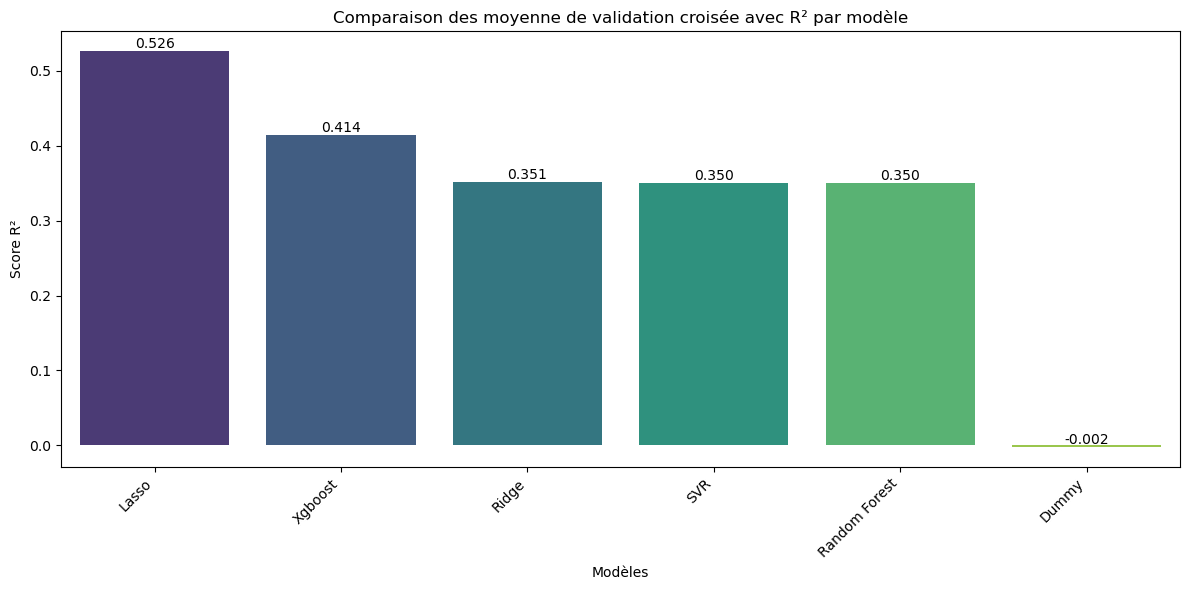

In [160]:
# Créer un DataFrame et trier
df = pd.DataFrame.from_dict(cross_val_scores, orient='index', columns=['R2 Score'])
df = df.sort_values('R2 Score', ascending=False)

# Configurer le style
plt.figure(figsize=(12, 6))

# Créer le graphique
bar_plot = sns.barplot(
    data=df,
    x=df.index,
    y='R2 Score',
    palette='viridis'
)

# Personnalisation
plt.title('Comparaison des moyenne de validation croisée avec R² par modèle')
plt.xlabel('Modèles')
plt.ylabel('Score R²')

# Rotation des labels
plt.xticks(rotation=45, ha='right')

# Ajouter les valeurs sur les barres
for i, v in enumerate(df['R2 Score']):
    bar_plot.text(i, v, f'{v:.3f}', ha='center', va='bottom')

# Ajuster la mise en page
plt.tight_layout()

# Afficher
plt.show()

In [40]:
X_train_scaled.shape

(1171, 332)

In [41]:
score_df

,MSE_Test,MAE_Test,RMSE_Test,R2_Test,MSE_Train,MAE_Train,RMSE_Train,R2_Train
Dummy,0.241524,0.319853,0.491451,-0.019569,1.000000,0.378123,1.000000,0.000000
Linear Regression,0.241524,0.319853,0.491451,-0.019569,0.103899,0.157699,0.322334,0.896101
SVR,0.289009,0.423653,0.537596,-0.220023,0.550067,0.151324,0.741665,0.449933
Random Forest,0.115470,0.166417,0.339809,0.512553,0.519149,0.194080,0.720520,0.480851
Lasso,0.061353,0.154887,0.247695,0.741006,0.241002,0.192557,0.490920,0.758998
Ridge,0.105474,0.201670,0.324768,0.554752,0.102494,0.152722,0.320146,0.897506
Xgboost,0.065922,0.126664,0.256752,0.721718,0.001468,0.026851,0.038309,0.998532


### Optimisation et interprétation du modèle

A réaliser :

- Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
- Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn.


### GridSearchCV

In [42]:
# Fonction plote les importances des features
def plot_feature_importance(model, X_train_scaled, y_train_scaled, feature_nb):
    results = permutation_importance(model, X_train_scaled, y_train_scaled, scoring='r2')

    # get importance
    importance = results.importances_mean

    importance_feature = pd.DataFrame(zip(importance, list(X_train_scaled.columns.values)), columns=["importance", "feature"])
    data = importance_feature.sort_values("importance", ascending=False).head(feature_nb)
    plt.bar(data["feature"], data["importance"], align="center", alpha=0.5)
    plt.ylabel('Importance')
    plt.title('Feature')
    plt.xticks(rotation=45, ha='right')
    plt.show()

Linear Regression

In [43]:
# LinearRegression
params = {
   'fit_intercept': [True, False],
   'copy_X': [True, False],
   'positive': [True, False],
   'n_jobs': [None, -1]
}

linear_grid = GridSearchCV(LinearRegression(), params, cv=5)
linear_grid.fit(X_train_scaled, y_train_scaled)
print(f"Best params: {linear_grid.best_params_}")

y_pred_test_gd_linear_regression = linear_grid.predict(X_test_scaled)

score_df = update_calculate_score(score_df, "Linear Regression", "Test", True, y_pred_test_gd_linear_regression, y_test_scaled)

Best params: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': True}


In [44]:
y_pred_train_gd_linear_regression = linear_grid.predict(X_train_scaled)

score_df = update_calculate_score(score_df, "Linear Regression", "Train", True, y_pred_train_gd_linear_regression, y_train_scaled)

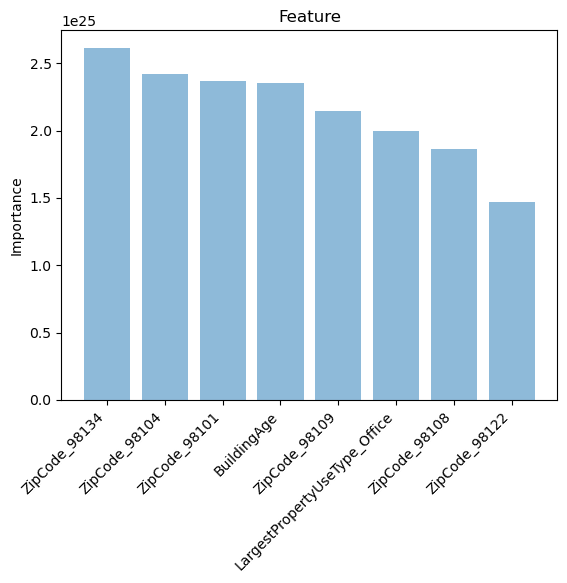

In [45]:
plot_feature_importance(linear_grid, X_train_scaled, y_train_scaled, 8)

Lasso

In [167]:
# Lasso
params = {
   'alpha': [0.001, 0.01, 0.1, 1, 10],
   'fit_intercept': [True, False],
   'max_iter': [1000, 2000],
   'selection': ['cyclic', 'random']
}

lasso_grid = GridSearchCV(lasso, params, cv=5)
lasso_grid.fit(X_train_scaled, y_train_scaled)
print(f"Best params: {lasso_grid.best_params_}")

y_pred_test_gd_lasso = lasso_grid.predict(X_test_scaled)

score_df = update_calculate_score(score_df, "Lasso", "Test", True, y_pred_test_gd_lasso, y_test_scaled)

Best params: {'alpha': 0.1, 'fit_intercept': False, 'max_iter': 1000, 'selection': 'random'}


In [168]:
lasso_ges_best_model = lasso_grid.best_estimator_

with open('app/model/lasso_ges.model', 'wb') as f:
    pickle.dump(lasso_ges_best_model, f)

In [48]:
y_pred_train_gd_lasso = lasso_grid.predict(X_train_scaled)

score_df = update_calculate_score(score_df, "Lasso", "Train", True, y_pred_train_gd_lasso, y_train_scaled)

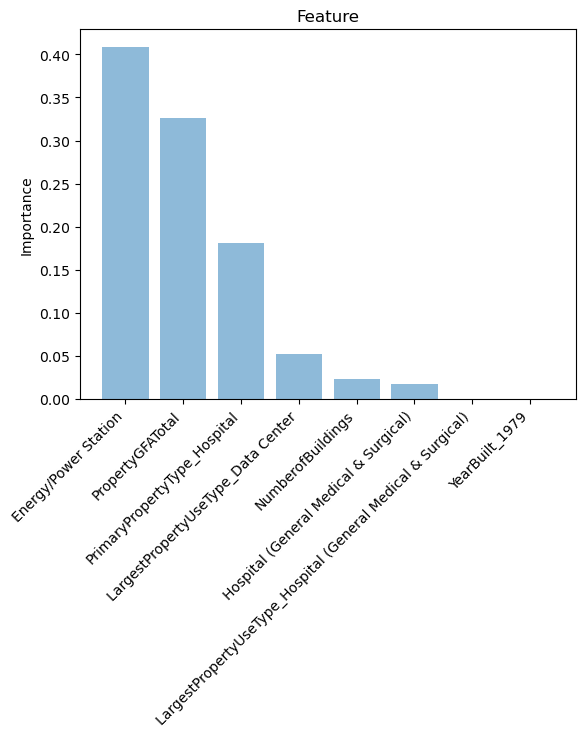

In [49]:
plot_feature_importance(lasso_grid, X_train_scaled, y_train_scaled, 8)

Ridge

In [50]:
# GridSearchCV sur Ridge
params = {
   'alpha': [0.001, 0.01, 0.1, 1, 10],
   'fit_intercept': [True, False],
   'max_iter': [500, 1000]
}

ridge_grid = GridSearchCV(ridge, params, cv=5)
ridge_grid.fit(X_train_scaled, y_train_scaled)
print(f"Best params: {ridge_grid.best_params_}")

# Tous les scores
scores_df = pd.DataFrame(ridge_grid.cv_results_)

y_pred_test_gd_ridge = ridge_grid.predict(X_test_scaled)

score_df = update_calculate_score(score_df, "Ridge", "Test", True, y_pred_test_gd_ridge, y_test_scaled)

Best params: {'alpha': 10, 'fit_intercept': False, 'max_iter': 500}


In [51]:
# Score sur la prédiction des données de train avec Ridge
y_pred_train_gd_ridge = ridge_grid.predict(X_train_scaled)

score_df = update_calculate_score(score_df, "Ridge", "Train", True, y_pred_train_gd_ridge, y_train_scaled)

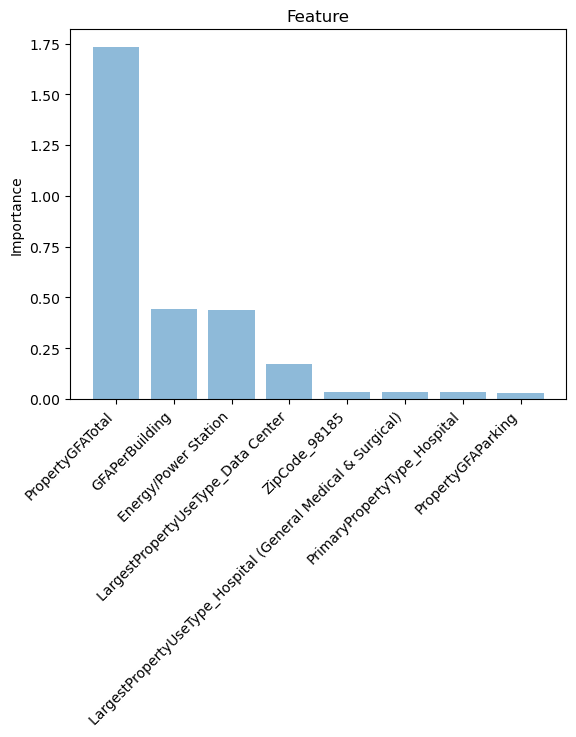

In [52]:
plot_feature_importance(ridge_grid, X_train_scaled, y_train_scaled, 8)

In [53]:
ridge_best_model = ridge_grid.best_estimator_

# Sauvegarde de modèle ridge
with open('app/model/ridge_energy.model', 'wb') as f:
    pickle.dump(ridge_best_model, f)

SVR

In [164]:
# SVR

params = {
    'kernel': ['rbf'],
    'C': [0.001, 0.01, 0.1, 1, 10],  
    'gamma': ['scale', 0.001, 0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 1]
}

# Initialisation SVR
svr = SVR(cache_size=3000, max_iter=3000)

svr_grid = GridSearchCV(svr, params, cv=5)
svr_grid.fit(X_train_scaled, y_train_scaled)
print(f"Best params: {svr_grid.best_params_}")

y_pred_test_gd_svr = svr_grid.predict(X_test_scaled)

score_df = update_calculate_score(score_df, "SVR", "Test", True, y_pred_test_gd_svr, y_test_scaled)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_i

Best params: {'C': 10, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [162]:
# Score sur la prédiction des données de train avec SVR
y_pred_train_gd_svr = svr_grid.predict(X_train_scaled)

score_df = update_calculate_score(score_df, "SVR", "Train", True, y_pred_train_gd_svr, y_train_scaled)

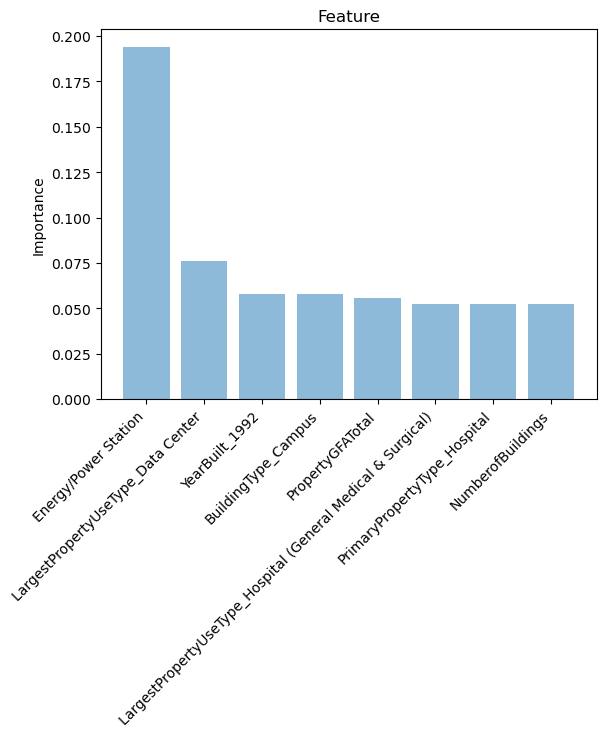

In [56]:
plot_feature_importance(svr_grid, X_train_scaled, y_train_scaled, 8)

RandomForestRegressor

In [83]:
# RandomForestRegressor

# Définition de la grille de paramètres à tester
params = {
    'n_estimators': [100, 200, 300],        # Nombre d'arbres
    'max_depth': [10, 20, 30, None],        # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],        # Nombre minimum d'échantillons pour diviser un nœud
    'min_samples_leaf': [1, 2, 4],          # Nombre minimum d'échantillons dans une feuille
    'max_features': ['auto', 'sqrt'],       # Nombre de features à considérer à chaque split
    'bootstrap': [True, False]  
}


rf_grid = GridSearchCV(
    estimator=random_forest,
    param_grid=params,
    cv=5,         
    n_jobs=-1,         
    scoring='r2',     
)

rf_grid.fit(X_train_scaled, y_train_scaled)
print(f"Best params: {rf_grid.best_params_}")

y_pred_test_gd_random_forest = rf_grid.predict(X_test_scaled)

score_df = update_calculate_score(score_df, "Random Forest", "Test", True, y_pred_test_gd_random_forest, y_test_scaled)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1080 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
987 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.11/site

Best params: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [81]:
# Score sur la prédiction des données de train avec Random Forest
y_pred_train_gd_random_forest = rf_grid.predict(X_train_scaled)

score_df = update_calculate_score(score_df, "Random Forest", "Train", True, y_pred_train_gd_random_forest, y_train_scaled)

In [92]:
# Sauvagarde de modèle
rf_best_model = rf_grid.best_estimator_

with open('app/model/rf_energy.model', 'wb') as f:
    pickle.dump(rf_best_model, f)

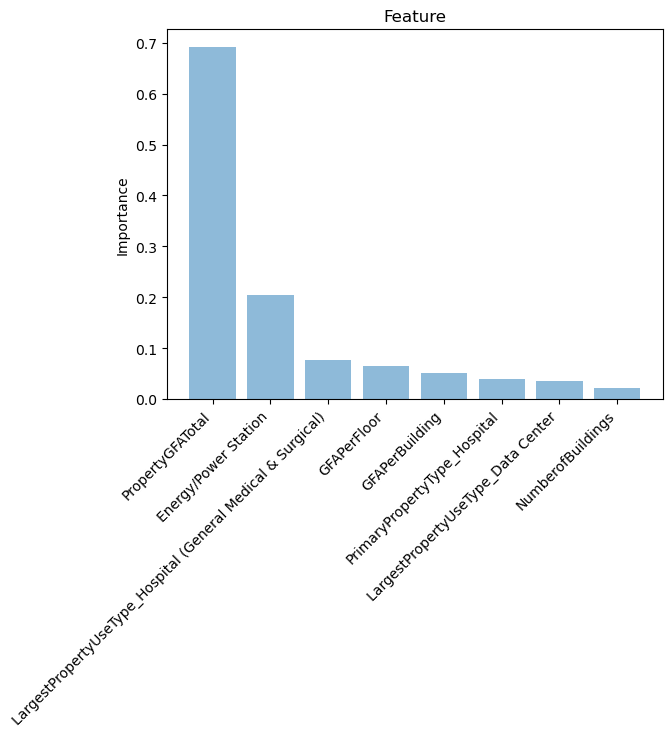

In [59]:
plot_feature_importance(rf_grid, X_train_scaled, y_train_scaled, 8)

Xgboost

In [60]:
# XGBOOST avec GridSearchCV

params = {
    'max_depth': [4, 6],  # Profondeur maximale de l'arbre
    'learning_rate': [0.01, 0.1, 0.3],  # Taux d'apprentissage
    'n_estimators': [100, 200, 300],  # Nombre d'arbres
    'subsample': [0.8, 1.0],  # Échantillonnage des données
    'colsample_bytree': [0.8, 1.0],  # Échantillonnage des features
    'gamma': [0, 0.1, 0.2]  # Gain minimum nécessaire pour effectuer une partition
}

# Configuration du modèle XGBoost
xgb = XGBRegressor()

# Configuration de la recherche par grille
xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=params,
    cv=5,
    n_jobs=-1, 
    scoring='r2',
    verbose=2
)

xgb_grid.fit(X_train_scaled, y_train_scaled)
print(f"Best params: {xgb_grid.best_params_}")


y_pred_test_gd_xgboost = xgb_grid.predict(X_test_scaled)

score_df = update_calculate_score(score_df, "Xgboost", "Test", True, y_pred_test_gd_xgboost, y_test_scaled)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}


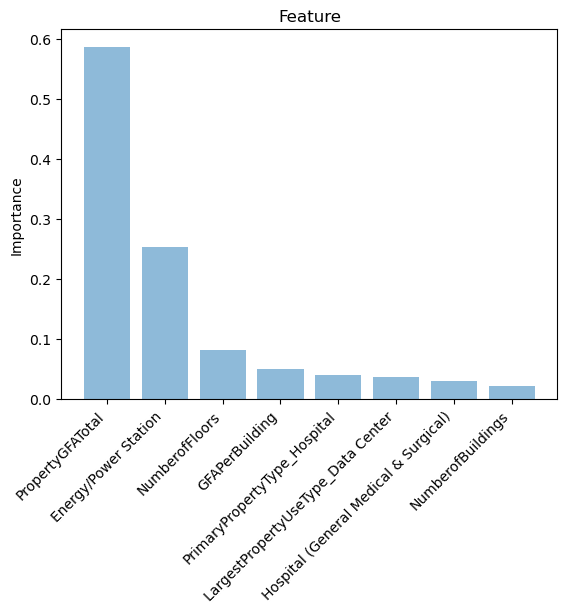

In [61]:
plot_feature_importance(xgb_grid, X_train_scaled, y_train_scaled, 8)

In [62]:
# Sauvagarde de modèle
xgb_best_model = xgb_grid.best_estimator_

with open('app/model/xgb_energy.model', 'wb') as f:
    pickle.dump(xgb_best_model, f)

In [63]:
# Score sur la prédiction des données de train avec Xgboost
y_pred_train_gd_xgboost = xgb_grid.predict(X_train_scaled)

score_df = update_calculate_score(score_df, "Xgboost", "Train", True, y_pred_train_gd_xgboost, y_train_scaled)

### Comparaison des métriques

In [64]:
score_df[["MSE_Test", "MSE_Test_gd", "MSE_Train", "MSE_Train_gd"]]

,MSE_Test,MSE_Test_gd,MSE_Train,MSE_Train_gd
Dummy,0.241524,NaN,1.000000,NaN
Linear Regression,0.241524,4.294727e+24,0.103899,0.137076
SVR,0.289009,4.652442e-01,0.550067,0.061659
Random Forest,0.115470,4.652442e-01,0.519149,0.078964
Lasso,0.061353,6.135265e-02,0.241002,0.241002
Ridge,0.105474,9.852885e-02,0.102494,0.106697
Xgboost,0.065922,6.467170e-02,0.001468,0.025173


In [85]:
score_df[["MSE_Test", "MSE_Test_gd", "MSE_Train", "MSE_Train_gd"]]

,MSE_Test,MSE_Test_gd,MSE_Train,MSE_Train_gd
Dummy,0.241524,NaN,1.000000,NaN
Linear Regression,0.241524,4.294727e+24,0.103899,1.370756e-01
SVR,0.289009,6.997331e-01,0.550067,6.165884e-02
Random Forest,0.115470,5.426290e-02,0.519149,7.211146e-30
Lasso,0.061353,6.135265e-02,0.241002,2.410024e-01
Ridge,0.105474,9.852885e-02,0.102494,1.066966e-01
Xgboost,0.065922,6.467170e-02,0.001468,2.517282e-02


In [86]:
score_df[["RMSE_Test", "RMSE_Test_gd", "RMSE_Train", "RMSE_Train_gd"]]

,RMSE_Test,RMSE_Test_gd,RMSE_Train,RMSE_Train_gd
Dummy,0.491451,NaN,1.000000,NaN
Linear Regression,0.491451,2.072372e+12,0.322334,3.702373e-01
SVR,0.537596,8.365005e-01,0.741665,2.483120e-01
Random Forest,0.339809,2.329440e-01,0.720520,2.685358e-15
Lasso,0.247695,2.476947e-01,0.490920,4.909199e-01
Ridge,0.324768,3.138931e-01,0.320146,3.266445e-01
Xgboost,0.256752,2.543063e-01,0.038309,1.586594e-01


In [143]:
score_df[["R2_Test", "R2_Train",]].sort_values("R2_Test", ascending=True)

,R2_Test,R2_Train
SVR,-0.220023,0.449933
Dummy,-0.019569,0.000000
Linear Regression,-0.019569,0.896101
Random Forest,0.512553,0.480851
Ridge,0.554752,0.897506
Xgboost,0.721718,0.998532
Lasso,0.741006,0.758998


In [144]:
score_df[["R2_Test", "R2_Test_gd", "R2_Train", "R2_Train_gd"]].sort_values("R2_Test_gd", ascending=True)

,R2_Test,R2_Test_gd,R2_Train,R2_Train_gd
Linear Regression,-0.019569,-1.812976e+25,0.896101,0.862924
SVR,-0.220023,-1.953854e+00,0.449933,0.938341
Ridge,0.554752,5.840702e-01,0.897506,0.893303
Xgboost,0.721718,7.269948e-01,0.998532,0.974827
Lasso,0.741006,7.410059e-01,0.758998,0.000000
Random Forest,0.512553,7.709345e-01,0.480851,1.000000
Dummy,-0.019569,NaN,0.000000,NaN


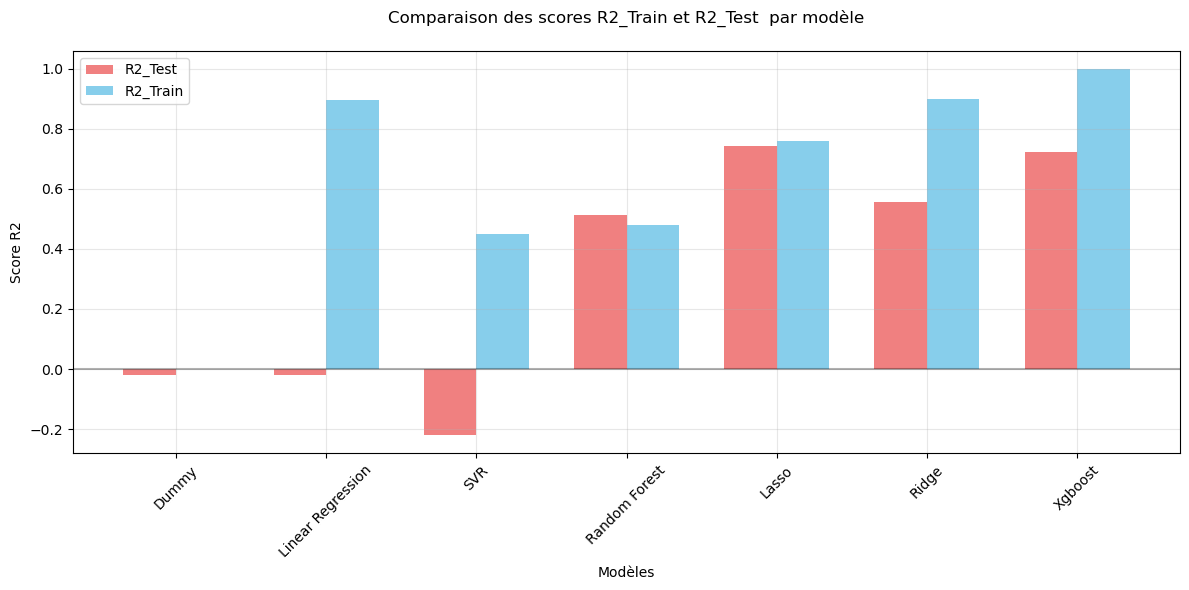


Différence entre R2 R2_Train et R2_Test (triée par ordre décroissant):
               Model  R2_Train   R2_Test  Difference
1  Linear Regression  0.896101 -0.019569    0.915670
2                SVR  0.449933 -0.220023    0.669956
5              Ridge  0.897506  0.554752    0.342754
6            Xgboost  0.998532  0.721718    0.276814
3      Random Forest  0.480851  0.512553    0.031702
0              Dummy  0.000000 -0.019569    0.019569
4              Lasso  0.758998  0.741006    0.017992


In [169]:
# Comparaison de R2 Test et R2 Train
plot_compare_scores(score_df, "R2_Test", "R2_Train")

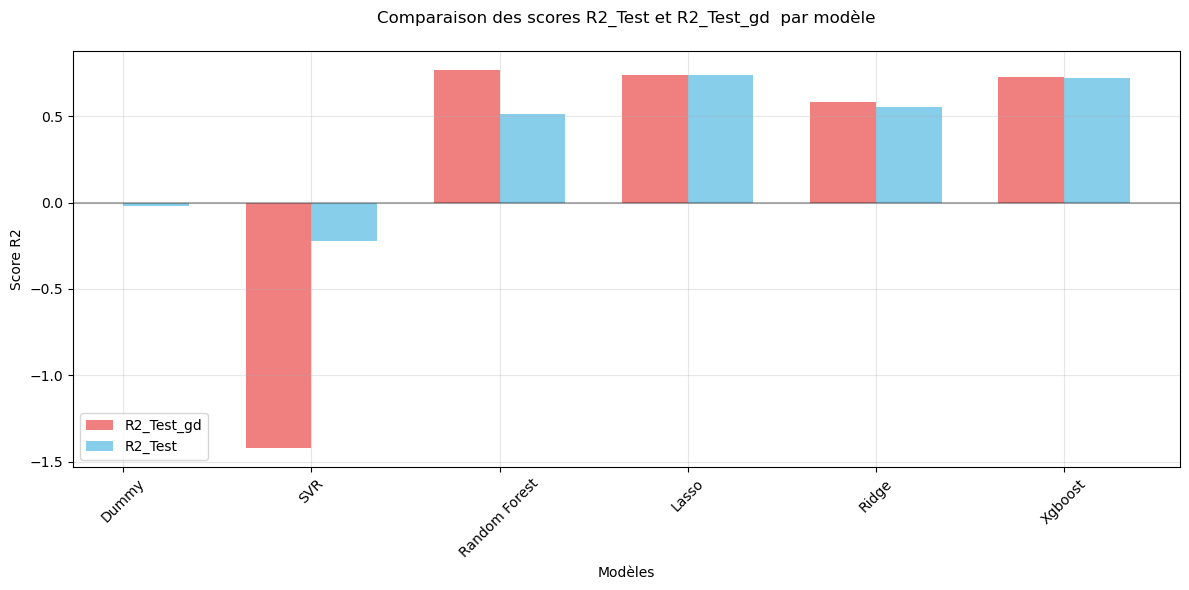


Différence entre R2 R2_Test et R2_Test_gd (triée par ordre décroissant):
           Model   R2_Test  R2_Test_gd    Difference
1            SVR -0.220023   -1.420827  1.200804e+00
2  Random Forest  0.512553    0.770935  2.583811e-01
4          Ridge  0.554752    0.584070  2.931798e-02
5        Xgboost  0.721718    0.726995  5.276618e-03
3          Lasso  0.741006    0.741006  2.226731e-08
0          Dummy -0.019569         NaN           NaN


In [170]:
# Comparaison de R2 sur GridsearchCV Test et R2 sur GridsearchCV  Train
plot_compare_scores(score_df.loc[score_df.index != "Linear Regression"], "R2_Test_gd", "R2_Test")

### Prédiction VS Réalité

In [190]:
df_real_pred_energy = pd.DataFrame({})
df_real_pred_energy["real"] = y_test
df_real_pred_energy["pred"] = scaler_y_energy.inverse_transform(y_pred_test_gd_lasso.reshape(-1, 1)).flatten()

In [191]:
df_real_pred_energy

,real,pred
1969,7.640945e+05,3.035411e+06
2080,2.133798e+06,3.294585e+06
785,2.186018e+06,3.760840e+06
2,7.258702e+07,4.606086e+07
2530,2.768448e+07,5.761168e+07
...,...,...
3012,5.959365e+05,4.836860e+06
293,2.668966e+07,3.861488e+07
400,1.769542e+07,6.783156e+06
1150,1.793851e+06,3.179104e+06


In [192]:
df_real_pred_energy['error_percentage'] = abs((df_real_pred_energy['real'] - df_real_pred_energy['pred']) / df_real_pred_energy['real']) * 100

# 2. Calculer la moyenne de l'erreur relative
mean_error_percentage = df_real_pred_energy['error_percentage'].mean()

print(f"Le modèle estime la consommation à ±{mean_error_percentage:.2f}% près")

# Pour voir plus de détails sur la distribution des erreurs
print("\nStatistiques des erreurs en pourcentage:")
print(df_real_pred_energy['error_percentage'].describe())

Le modèle estime la consommation à ±235.83% près

Statistiques des erreurs en pourcentage:
count     293.000000
mean      235.832924
std       486.249353
min         0.173779
25%        36.279328
50%        83.138296
75%       228.597626
max      4776.230582
Name: error_percentage, dtype: float64


## Modèle pour TotalGESemission

In [115]:
ges_score_df = pd.DataFrame({})

Lasso

In [121]:
# Lasso
params = {
   'alpha': [0.001, 0.01, 0.1, 1, 10],
   'fit_intercept': [True, False],
   'max_iter': [1000, 2000],
   'selection': ['cyclic', 'random']
}

lasso_ges_grid = GridSearchCV(lasso, params, cv=5)
lasso_ges_grid.fit(X_train_scaled, y_train_ges_scaled)
print(f"Best params: {lasso_ges_grid.best_params_}")

y_pred_test_ges_gd_lasso = lasso_ges_grid.predict(X_test_scaled)

ges_score_df = update_calculate_score(ges_score_df, "Lasso", "Test", True, y_pred_test_ges_gd_lasso, y_test_scaled)

Best params: {'alpha': 0.01, 'fit_intercept': False, 'max_iter': 1000, 'selection': 'random'}


In [122]:
lasso_ges_best_model = lasso_ges_grid.best_estimator_

with open('app/model/lasso_ges.model', 'wb') as f:
    pickle.dump(lasso_ges_best_model, f)

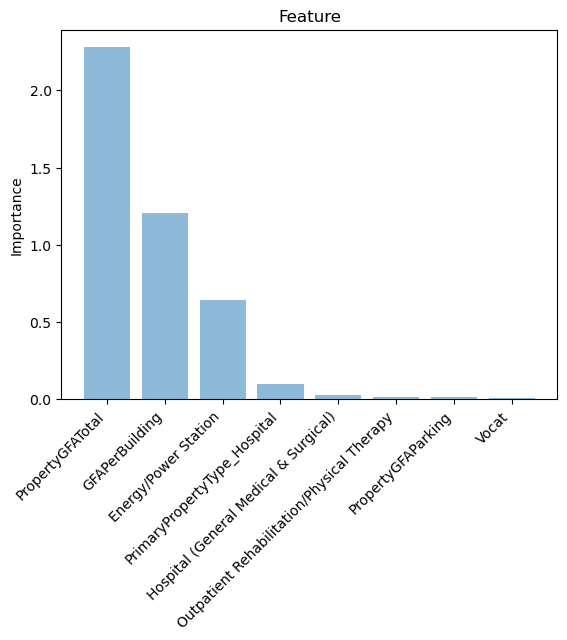

In [123]:
y_pred_train_gd_lasso = lasso_ges_grid.predict(X_train_scaled)

ges_score_df = update_calculate_score(ges_score_df, "Lasso", "Train", True, y_pred_train_gd_lasso, y_train_ges_scaled)
plot_feature_importance(lasso_ges_grid, X_train_scaled, y_train_ges_scaled, 8)

In [124]:
ges_score_df

,MSE_Test_gd,MAE_Test_gd,RMSE_Test_gd,R2_Test_gd,MSE_Train_gd,MAE_Train_gd,RMSE_Train_gd,R2_Train_gd
Lasso,0.116164,0.198005,0.340829,0.509625,0.106532,0.13899,0.326392,0.893468


Random Forest

In [125]:
# RandomForestRegressor

# Définition de la grille de paramètres à tester
params = {
    'n_estimators': [100, 200, 300],        # Nombre d'arbres
    'max_depth': [10, 20, 30, None],        # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],        # Nombre minimum d'échantillons pour diviser un nœud
    'min_samples_leaf': [1, 2, 4],          # Nombre minimum d'échantillons dans une feuille
    'max_features': ['auto', 'sqrt'],       # Nombre de features à considérer à chaque split
    'bootstrap': [True, False]  
}


rf_ges_grid = GridSearchCV(
    estimator=random_forest,
    param_grid=params,
    cv=5,         
    n_jobs=-1,         
    scoring='r2',     
)

rf_ges_grid.fit(X_train_scaled, y_train_ges_scaled)

y_pred_test_ges_gd_random_forest = rf_ges_grid.predict(X_test_scaled)

ges_score_df = update_calculate_score(ges_score_df, "Random Forest", "Test", True, y_pred_test_ges_gd_random_forest, y_test_ges_scaled)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1080 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
494 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.11/site

In [126]:
# Score sur la prédiction des données de train avec Random Forest
y_pred_train_ges_gd_random_forest = rf_ges_grid.predict(X_train_scaled)

ges_score_df = update_calculate_score(ges_score_df, "Random Forest", "Train", True, y_pred_train_ges_gd_random_forest, y_train_ges_scaled)

In [127]:
# Sauvagarde de modèle
rf_ges_best_model = rf_ges_grid.best_estimator_

with open('app/model/rf_ges.model', 'wb') as f:
    pickle.dump(rf_ges_best_model, f)

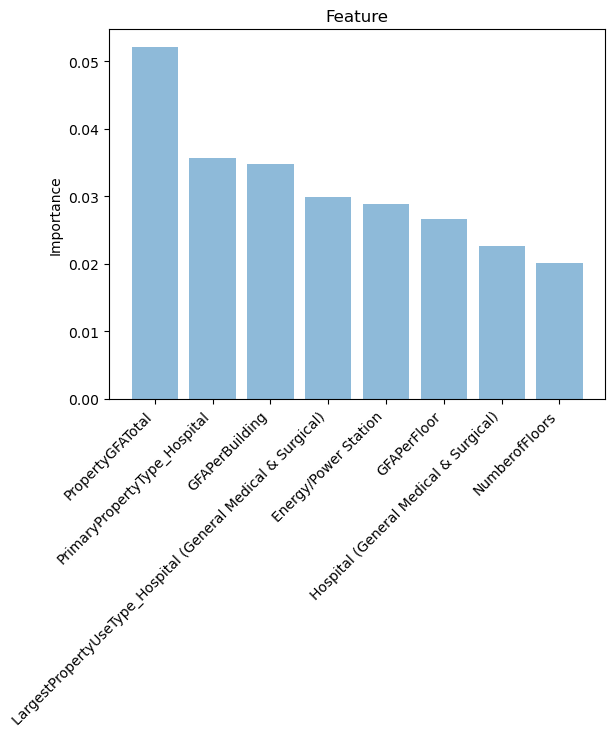

In [129]:
plot_feature_importance(rf_ges_grid, X_train_scaled, y_train_ges_scaled, 8)

In [130]:
ges_score_df

,MSE_Test_gd,MAE_Test_gd,RMSE_Test_gd,R2_Test_gd,MSE_Train_gd,MAE_Train_gd,RMSE_Train_gd,R2_Train_gd
Lasso,0.116164,0.198005,0.340829,0.509625,1.065319e-01,1.389901e-01,3.263922e-01,0.893468
Random Forest,0.063457,0.112236,0.251906,0.466132,1.735924e-29,1.026529e-15,4.166442e-15,1.000000


Xgboost

In [137]:
# XGBOOST avec GridSearchCV

params = {
    'max_depth': [4, 6],  # Profondeur maximale de l'arbre
    'learning_rate': [0.01, 0.1, 0.3],  # Taux d'apprentissage
    'n_estimators': [100, 200, 300],  # Nombre d'arbres
    'subsample': [0.8, 1.0],  # Échantillonnage des données
    'colsample_bytree': [0.8, 1.0],  # Échantillonnage des features
    'gamma': [0, 0.1, 0.2]  # Gain minimum nécessaire pour effectuer une partition
}

# Configuration du modèle XGBoost
xgb_ges = XGBRegressor()

# Configuration de la recherche par grille
xgb_ges_grid = GridSearchCV(
    estimator=xgb_ges,
    param_grid=params,
    cv=5,
    n_jobs=-1, 
    scoring='r2',
    verbose=2
)

xgb_ges_grid.fit(X_train_scaled, y_train_ges_scaled)
print(f"Best params: {xgb_grid.best_params_}")


y_pred_test_ges_gd_xgboost = xgb_ges_grid.predict(X_test_scaled)

ges_score_df = update_calculate_score(ges_score_df, "Xgboost", "Test", True, y_pred_test_ges_gd_xgboost, y_test_ges_scaled)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}


In [138]:
# Sauvagarde de modèle
xgb_ges_best_model = xgb_ges_grid.best_estimator_

with open('app/model/xgb_ges.model', 'wb') as f:
    pickle.dump(xgb_ges_best_model, f)

In [139]:
# Score sur la prédiction des données de train avec Xgboost
y_pred_train_ges_gd_xgboost = xgb_ges_grid.predict(X_train_scaled)

ges_score_df = update_calculate_score(ges_score_df, "Xgboost", "Train", True, y_pred_train_ges_gd_xgboost, y_train_ges_scaled)

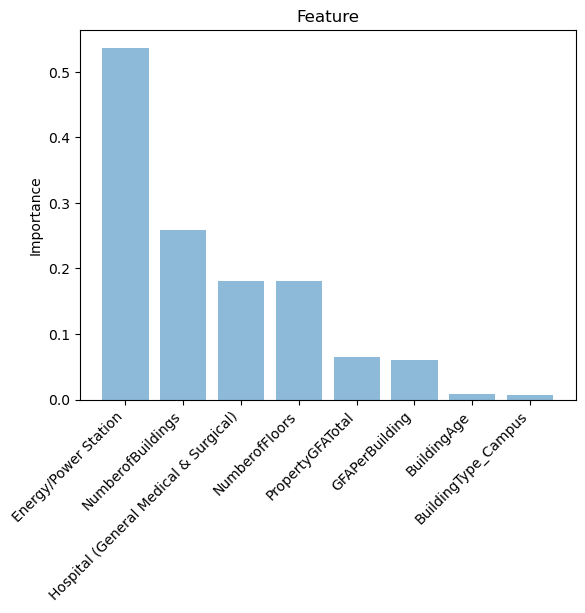

In [140]:
plot_feature_importance(xgb_ges_grid, X_train_scaled, y_train_ges_scaled, 8)

In [142]:
ges_score_df

,MSE_Test_gd,MAE_Test_gd,RMSE_Test_gd,R2_Test_gd,MSE_Train_gd,MAE_Train_gd,RMSE_Train_gd,R2_Train_gd
Lasso,0.116164,0.198005,0.340829,0.509625,1.065319e-01,1.389901e-01,3.263922e-01,0.893468
Random Forest,0.063457,0.112236,0.251906,0.466132,1.735924e-29,1.026529e-15,4.166442e-15,1.000000
Xgboost,0.152760,0.127297,0.390845,-0.285187,1.731571e-02,7.986076e-02,1.315892e-01,0.982684


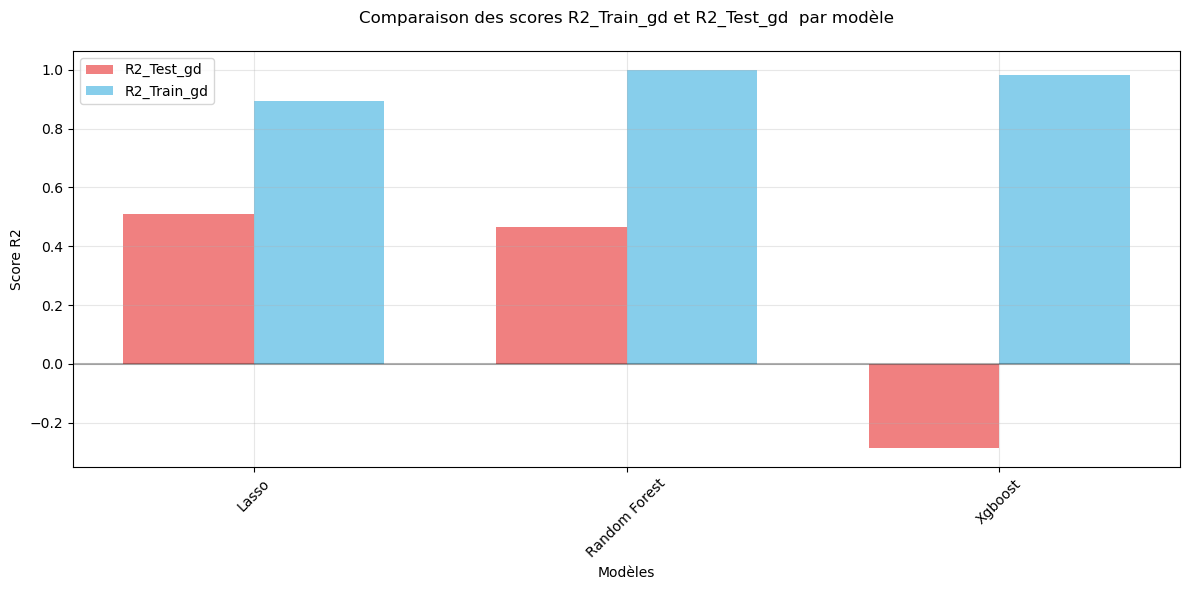


Différence entre R2 R2_Train_gd et R2_Test_gd (triée par ordre décroissant):
           Model  R2_Train_gd  R2_Test_gd  Difference
2        Xgboost     0.982684   -0.285187    1.267871
1  Random Forest     1.000000    0.466132    0.533868
0          Lasso     0.893468    0.509625    0.383843


In [193]:
plot_compare_scores(ges_score_df, "R2_Test_gd", "R2_Train_gd")